# **Working memory training**: behavioral progress during fMRI scanning sessions

The code below allows to visualize and analize data from 6-week working memory training study. Participants were scanned four times while performing dual n-back (Jaeggi et al., 2018). 

Three performance measures were calculated: 

- accuracy
- d-prime (dprime)
- penallized reaction time (prt)

We additionally calculated block-to-block standard diviation for each of this measures.


**Last edited:** 21-11-2019

Step 0: Setup
--------------------------------------

In [31]:
# Loading packages
library(psych)
library(tidyverse)
library(data.table)
library(nlme)
library(broom)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1)

Step 1: Preparing data
--------------------------------------

In [32]:
# Setting working directory
setwd("~/Dropbox/Projects/LearningBrain/")

# Loading data
performance <- read.csv("data/behavioral/WM_fmri_behaviour_mean_tidy.csv")
performance$Group <- factor(performance$Group, levels = c('Control', 'Experimental'))
performance$Session <- factor(performance$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))

# Removing subjects with high motion
performance <- performance %>% filter(!(Subject %in% c('sub-13', 'sub-21', 'sub-23', 'sub-50')))
head(performance)

Subject,Session,Condition,Accuracy,pRT,Dprime,Group
sub-01,Naive,1-back,0.8666667,1001.033,3.437119,Control
sub-01,Naive,2-back,0.7833333,1433.765,2.514055,Control
sub-01,Early,1-back,0.8666667,1003.172,3.429125,Control
sub-01,Early,2-back,0.8666667,1282.489,3.117902,Control
sub-01,Middle,1-back,0.8000000,1178.238,2.758558,Control
sub-01,Middle,2-back,0.9000000,1108.405,3.460899,Control


Step 2: Multilevel modelling (MLM): pRT change
----------------------------------------------------

In [33]:
baseline <- lme(pRT ~ 1, random = ~ 1|Subject/Session/Condition, data = performance, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
condition <- update(baseline, .~. + Condition)
session <- update(condition, .~. + Session)
group <- update(session, .~. + Group)

condition_session <- update(group, .~. + Condition:Session)
condition_group <- update(condition_session, .~. + Condition:Group)
session_group <- update(condition_group, .~. + Session:Group)
condition_session_group <- update(session_group, .~. + Condition:Session:Group)

anova(baseline, condition, session, group, condition_session, condition_group, session_group, condition_session_group)
summary(condition_session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = pRT ~ 1, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,5,4442.475,4461.561,-2216.238,,NA,NA
condition,"lme.formula(fixed = pRT ~ Condition, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,6,4378.607,4401.510,-2183.304,1 vs 2,65.867956,4.821674e-16
session,"lme.formula(fixed = pRT ~ Condition + Session, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,9,4311.315,4345.669,-2146.658,2 vs 3,73.291849,8.416934e-16
group,"lme.formula(fixed = pRT ~ Condition + Session + Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,10,4309.607,4347.778,-2144.803,3 vs 4,3.708671,5.413048e-02
condition_session,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",5,13,4286.359,4335.981,-2130.179,4 vs 5,29.248067,1.986115e-06
condition_group,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session + Condition:Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",6,14,4234.832,4288.272,-2103.416,5 vs 6,53.526681,2.551045e-13
session_group,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",7,17,4209.608,4274.499,-2087.804,6 vs 7,31.223680,7.626784e-07
condition_session_group,"lme.formula(fixed = pRT ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group + Condition:Session:Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",8,20,4198.825,4275.167,-2079.413,7 vs 8,16.783077,7.831763e-04


Linear mixed-effects model fit by maximum likelihood
 Data: performance 
       AIC      BIC    logLik
  4198.825 4275.167 -2079.413

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:    152.2143

 Formula: ~1 | Session %in% Subject
        (Intercept)
StdDev:    60.33148

 Formula: ~1 | Condition %in% Session %in% Subject
        (Intercept) Residual
StdDev:    75.77678 35.42955

Fixed effects: pRT ~ Condition + Session + Group + Condition:Session + Condition:Group +      Session:Group + Condition:Session:Group 
                                                    Value Std.Error  DF
(Intercept)                                     1071.1208  41.11354 160
Condition2-back                                  231.9087  26.45255 160
SessionEarly                                     -23.3870  32.61481 120
SessionMiddle                                    -45.3464  32.61481 120
SessionLate                                      -66.1583  32.61481 120
GroupExperimental               

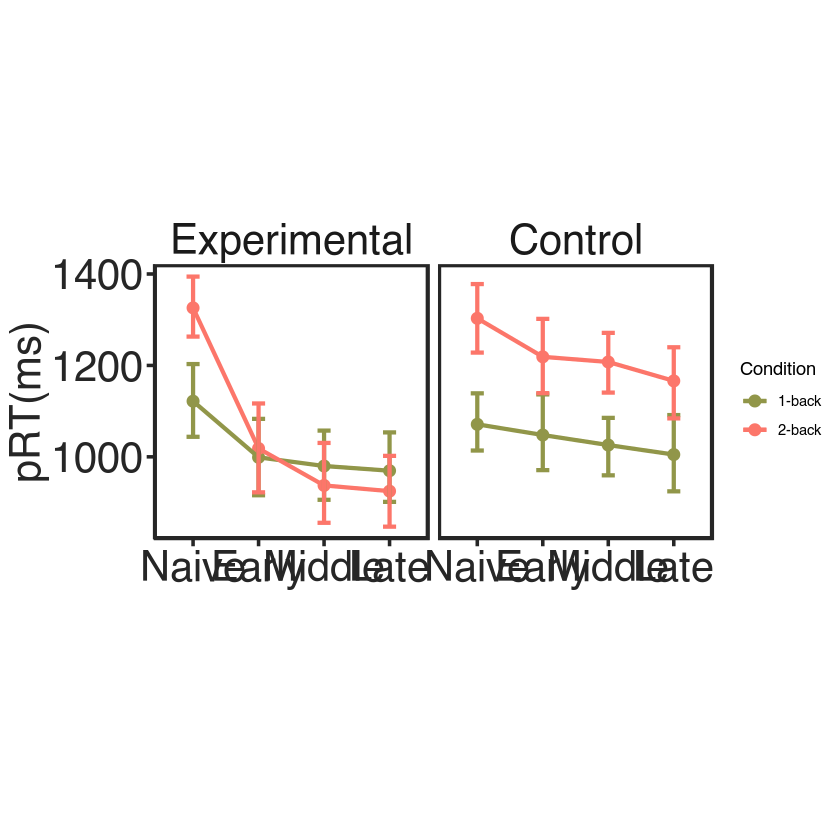

In [63]:
performance$Group <- factor(performance$Group, levels = c('Experimental', 'Control'))

p <- ggplot(performance, aes(x = Session, y = pRT, color = Condition)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Condition)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#919649', '#fc766a')) +
    theme_training +
    ylab('pRT(ms)') +
    xlab('') +
    facet_wrap('~Group')
p

ggsave("figures/prt_lineplot.pdf", plot = p, width = 12, height = 6, dpi = 300)  

Step 3: T-tests: pRT change
----------------------------------------------------

In [34]:
# Differences between first and last sessions for each group and task conditions
beh_mean_nl <- performance %>% filter(Session %in% c('Naive', 'Late'))

exp1 <-  beh_mean_nl %>% filter(Group == 'Experimental') %>% filter(Condition == '1-back')
exp2 <-  beh_mean_nl %>% filter(Group == 'Experimental') %>% filter(Condition == '2-back')
con1 <-  beh_mean_nl %>% filter(Group == 'Control') %>% filter(Condition == '1-back')
con2 <-  beh_mean_nl %>% filter(Group == 'Control') %>% filter(Condition == '2-back')

In [35]:
t.test(exp1$pRT ~ exp1$Session, paired = TRUE)
t.test(exp2$pRT ~ exp2$Session, paired = TRUE)
t.test(con1$pRT ~ con1$Session, paired = TRUE)
t.test(con2$pRT ~ con2$Session, paired = TRUE)


	Paired t-test

data:  exp1$pRT by exp1$Session
t = 4.606, df = 20, p-value = 0.000171
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  83.22169 220.99674
sample estimates:
mean of the differences 
               152.1092 



	Paired t-test

data:  exp2$pRT by exp2$Session
t = 9.3352, df = 20, p-value = 9.931e-09
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 311.3232 490.4905
sample estimates:
mean of the differences 
               400.9069 



	Paired t-test

data:  con1$pRT by con1$Session
t = 1.8379, df = 20, p-value = 0.08098
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  -8.930798 141.247453
sample estimates:
mean of the differences 
               66.15833 



	Paired t-test

data:  con2$pRT by con2$Session
t = 3.6959, df = 20, p-value = 0.001431
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  59.6383 214.1842
sample estimates:
mean of the differences 
               136.9113 


In [36]:
# Differences in changes of modularity between groups

t.test(exp2[exp2$Session == 'Naive', ]$pRT - exp2[exp2$Session == 'Late', ]$pRT,
con2[con2$Session == 'Naive', ]$pRT - con2[con2$Session == 'Late', ]$pRT, paired = FALSE)

t.test(exp1[exp1$Session == 'Naive', ]$pRT - exp1[exp1$Session == 'Late', ]$pRT,
con1[con1$Session == 'Naive', ]$pRT - con1[con1$Session == 'Late', ]$pRT, paired = FALSE)



	Welch Two Sample t-test

data:  exp2[exp2$Session == "Naive", ]$pRT - exp2[exp2$Session == "Late",  and con2[con2$Session == "Naive", ]$pRT - con2[con2$Session == "Late",     ]$pRT and     ]$pRT
t = 4.6547, df = 39.157, p-value = 3.672e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 149.2927 378.6985
sample estimates:
mean of x mean of y 
 400.9069  136.9113 



	Welch Two Sample t-test

data:  exp1[exp1$Session == "Naive", ]$pRT - exp1[exp1$Session == "Late",  and con1[con1$Session == "Naive", ]$pRT - con1[con1$Session == "Late",     ]$pRT and     ]$pRT
t = 1.7595, df = 39.706, p-value = 0.0862
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -12.80328 184.70506
sample estimates:
mean of x mean of y 
152.10922  66.15833 


In [49]:
# Difference between 1-back and 2-back pRT in the last session (Experimental)
t.test(exp1[exp1$Session == 'Late', ]$pRT, exp2[exp2$Session == 'Late', ]$pRT, paired = TRUE)

# Difference between 1-back and 2-back pRT in the last session (Control)
t.test(con1[con1$Session == 'Late', ]$pRT, con2[con2$Session == 'Late', ]$pRT, paired = TRUE)


	Paired t-test

data:  exp1[exp1$Session == "Late", ]$pRT and exp2[exp2$Session == "Late", ]$pRT
t = 2.0176, df = 20, p-value = 0.05726
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.515508 90.918740
sample estimates:
mean of the differences 
               44.70162 



	Paired t-test

data:  con1[con1$Session == "Late", ]$pRT and con2[con2$Session == "Late", ]$pRT
t = -4.1375, df = 20, p-value = 0.00051
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -242.40336  -79.90827
sample estimates:
mean of the differences 
              -161.1558 


In [41]:
summary_performance <- performance %>% 
    group_by(Session, Group, Condition) %>% filter(Session %in% c('Naive', 'Late'))%>%
    summarize(mpRT = mean(pRT), mDprime = mean(Dprime), mAcc = mean(Accuracy))

summary_performance 

Session,Group,Condition,mpRT,mDprime,mAcc
Naive,Control,1-back,1071.1208,3.298577,0.8682540
Naive,Control,2-back,1303.0295,2.135787,0.6769841
Naive,Experimental,1-back,1121.7615,3.017384,0.8277778
Naive,Experimental,2-back,1325.8576,1.949630,0.6206349
Late,Control,1-back,1004.9625,3.577217,0.8912698
Late,Control,2-back,1166.1183,2.822876,0.7880952
Late,Experimental,1-back,969.6523,3.438286,0.8650794
Late,Experimental,2-back,924.9507,3.436223,0.8626984


In [51]:
# Percentage of improvement
1 - (summary_performance %>% filter(Session=='Naive') / summary_performance %>% filter(Session=='Late')) %>% 
select(mpRT, mDprime, mAcc) 

Warning message in Ops.factor(left, right):
“‘/’ not meaningful for factors”Warning message in Ops.factor(left, right):
“‘/’ not meaningful for factors”Warning message in Ops.factor(left, right):
“‘/’ not meaningful for factors”

mpRT,mDprime,mAcc
-0.06583164,0.07789289,0.02582369
-0.11740769,0.24340043,0.14098691
-0.15686985,0.12241640,0.04311927
-0.43343593,0.43262419,0.28058878


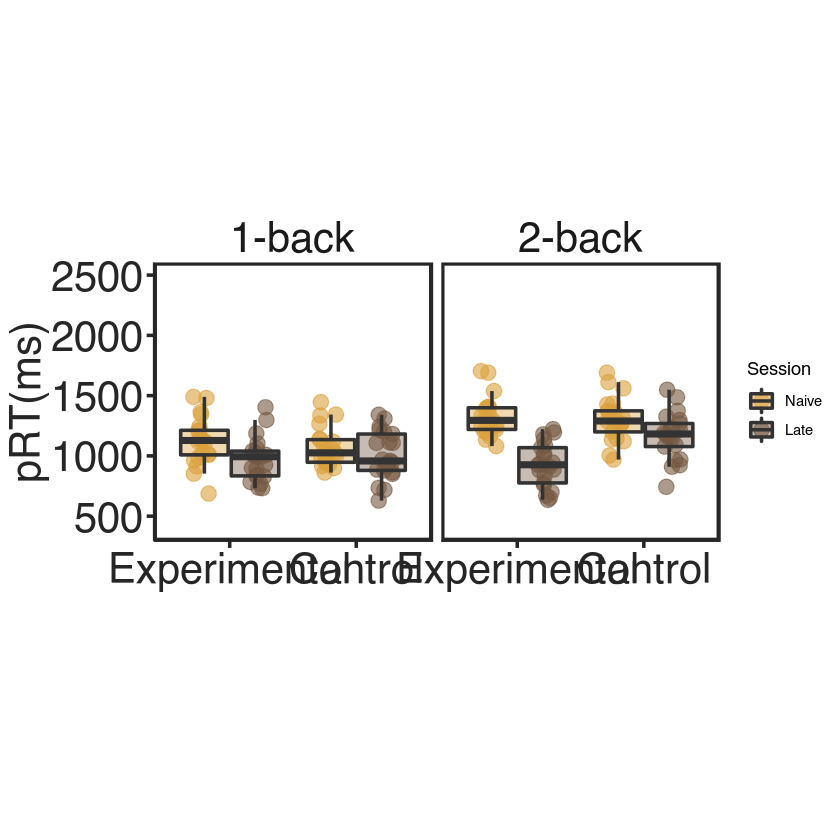

In [65]:
p <- performance %>% filter(Session %in% c('Naive', 'Late')) %>%
    ggplot(aes(x = Group, y = pRT, fill = Session)) + 
    geom_point(aes(col = Session), position=position_jitterdodge(dodge.width=0.9), alpha = 0.6, size = 4) +
    geom_boxplot(alpha = 0.4, outlier.shape = NA, position=position_dodge(width=0.8), size = 1) + 
    scale_fill_manual(values=c('#daa03d', '#755841')) +
    scale_color_manual(values=c('#daa03d', '#755841')) +
    facet_wrap(~Condition) +
    ylim(400, 2500) +
    ylab('pRT(ms)') +
    xlab(' ') +
    theme_training
p

ggsave("figures/prt_ttests.pdf", plot = p, width = 12, height = 6, dpi = 300)  

Step 4: Multilevel modelling (MLM): d-prime change
----------------------------------------------------

In [45]:
baseline <- lme(Dprime ~ 1, random = ~ 1|Subject/Session/Condition, data = performance, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
condition <- update(baseline, .~. + Condition)
session <- update(condition, .~. + Session)
group <- update(session, .~. + Group)

condition_session <- update(group, .~. + Condition:Session)
condition_group <- update(condition_session, .~. + Condition:Group)
session_group <- update(condition_group, .~. + Session:Group)
condition_session_group <- update(session_group, .~. + Condition:Session:Group)

anova(baseline, condition, session, group, condition_session, condition_group, session_group, condition_session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = Dprime ~ 1, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,5,752.4170,771.5025,-371.2085,,NA,NA
condition,"lme.formula(fixed = Dprime ~ Condition, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,6,660.2039,683.1066,-324.1020,1 vs 2,94.213051,2.833265e-22
session,"lme.formula(fixed = Dprime ~ Condition + Session, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,9,593.8587,628.2127,-287.9293,2 vs 3,72.345245,1.342635e-15
group,"lme.formula(fixed = Dprime ~ Condition + Session + Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,10,593.6771,631.8482,-286.8385,3 vs 4,2.181581,1.396709e-01
condition_session,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",5,13,567.3210,616.9435,-270.6605,4 vs 5,32.356052,4.402907e-07
condition_group,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",6,14,537.4199,590.8595,-254.7100,5 vs 6,31.901122,1.622234e-08
session_group,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",7,17,518.6824,583.5733,-242.3412,6 vs 7,24.737460,1.752040e-05
condition_session_group,"lme.formula(fixed = Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group + Session:Group + Condition:Session:Group, data = performance, random = ~1 | Subject/Session/Condition, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",8,20,515.2919,591.6342,-237.6460,7 vs 8,9.390509,2.452514e-02


In [14]:
summary(condition_session_group)

Linear mixed-effects model fit by maximum likelihood
 Data: performance 
       AIC      BIC    logLik
  545.2038 623.3655 -252.6019

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:   0.4160785

 Formula: ~1 | Session %in% Subject
        (Intercept)
StdDev:   0.1555252

 Formula: ~1 | Condition %in% Session %in% Subject
        (Intercept) Residual
StdDev:   0.3723392 0.132817

Fixed effects: Dprime ~ Condition + Session + Group + Condition:Session + Condition:Group +      Session:Group + Condition:Session:Group 
                                                Value Std.Error  DF   t-value
(Intercept)                                 3.0618698 0.1267758 176 24.151847
Condition2-back                            -1.0583533 0.1191931 176 -8.879319
SessionEarly                                0.5159852 0.1280855 132  4.028442
SessionMiddle                               0.3672700 0.1280855 132  2.867381
SessionLate                                 0.4190064 0.1280855 132  3.

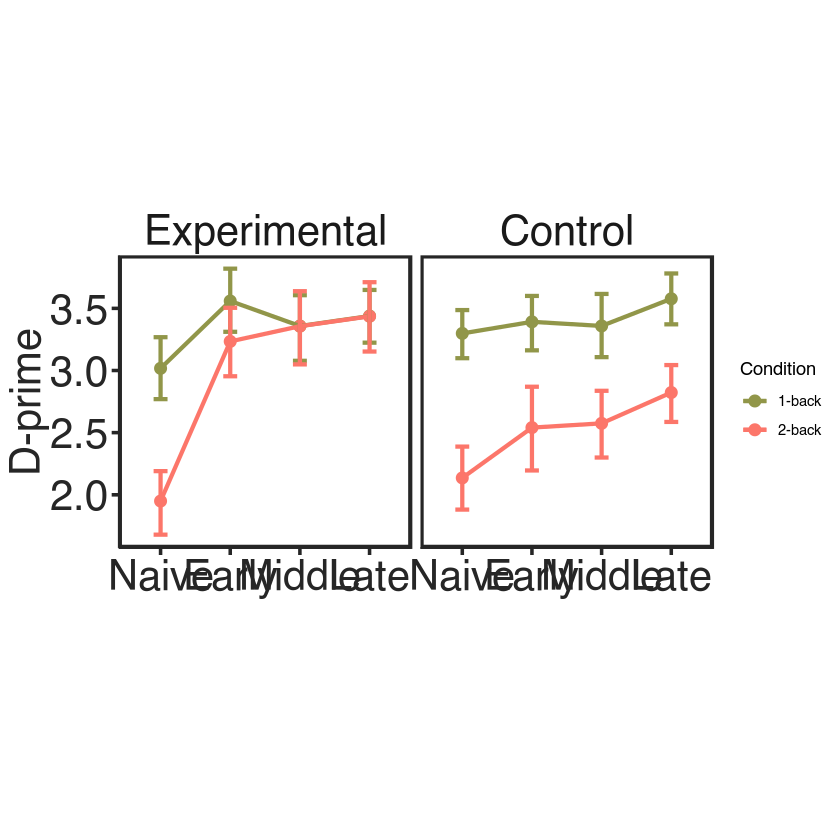

In [66]:
p <- ggplot(performance, aes(x = Session, y = Dprime, color = Condition)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Condition)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#919649', '#fc766a')) +
    theme_training +
    ylab('D-prime') +
    xlab('') +
    facet_wrap('~Group')

p

ggsave("figures/dprime_lineplot.pdf", plot = p, width = 12, height = 6, dpi = 300)  

Step 4: T-tests: d-prime change
----------------------------------------------------

In [47]:
t.test(exp1$Dprime ~ exp1$Session, paired = TRUE)
t.test(exp2$Dprime ~ exp2$Session, paired = TRUE)
t.test(con1$Dprime ~ con1$Session, paired = TRUE)
t.test(con2$Dprime ~ con2$Session, paired = TRUE)


	Paired t-test

data:  exp1$Dprime by exp1$Session
t = -3.1859, df = 20, p-value = 0.004643
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6964893 -0.1453159
sample estimates:
mean of the differences 
             -0.4209026 



	Paired t-test

data:  exp2$Dprime by exp2$Session
t = -9.1731, df = 20, p-value = 1.323e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.824645 -1.148541
sample estimates:
mean of the differences 
              -1.486593 



	Paired t-test

data:  con1$Dprime by con1$Session
t = -1.9172, df = 20, p-value = 0.0696
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.58180020  0.02452066
sample estimates:
mean of the differences 
             -0.2786398 



	Paired t-test

data:  con2$Dprime by con2$Session
t = -6.451, df = 20, p-value = 2.726e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.9092642 -0.4649142
sample estimates:
mean of the differences 
             -0.6870892 


In [48]:
t.test(exp2[exp2$Session == 'Naive', ]$Dprime - exp2[exp2$Session == 'Late', ]$Dprime,
con2[con2$Session == 'Naive', ]$Dprime - con2[con2$Session == 'Late', ]$Dprime, paired = FALSE)

t.test(exp1[exp1$Session == 'Naive', ]$Dprime - exp1[exp1$Session == 'Late', ]$Dprime,
con1[con1$Session == 'Naive', ]$Dprime - con1[con1$Session == 'Late', ]$Dprime, paired = FALSE)



	Welch Two Sample t-test

data:  exp2[exp2$Session == "Naive", ]$Dprime - exp2[exp2$Session ==  and con2[con2$Session == "Naive", ]$Dprime - con2[con2$Session ==     "Late", ]$Dprime and     "Late", ]$Dprime
t = -4.1227, df = 34.561, p-value = 0.0002224
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1933766 -0.4056317
sample estimates:
 mean of x  mean of y 
-1.4865933 -0.6870892 



	Welch Two Sample t-test

data:  exp1[exp1$Session == "Naive", ]$Dprime - exp1[exp1$Session ==  and con1[con1$Session == "Naive", ]$Dprime - con1[con1$Session ==     "Late", ]$Dprime and     "Late", ]$Dprime
t = -0.72432, df = 39.642, p-value = 0.4731
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5393303  0.2548046
sample estimates:
 mean of x  mean of y 
-0.4209026 -0.2786398 


In [50]:
# Difference between 1-back and 2-back pRT in the last session (Experimental)
t.test(exp1[exp1$Session == 'Late', ]$Dprime, exp2[exp2$Session == 'Late', ]$Dprime, paired = TRUE)

# Difference between 1-back and 2-back pRT in the last session (Control)
t.test(con1[con1$Session == 'Late', ]$Dprime, con2[con2$Session == 'Late', ]$Dprime, paired = TRUE)


	Paired t-test

data:  exp1[exp1$Session == "Late", ]$Dprime and exp2[exp2$Session == "Late", ]$Dprime
t = 0.023354, df = 20, p-value = 0.9816
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1822009  0.1863269
sample estimates:
mean of the differences 
             0.00206299 



	Paired t-test

data:  con1[con1$Session == "Late", ]$Dprime and con2[con2$Session == "Late", ]$Dprime
t = 4.913, df = 20, p-value = 8.397e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4340626 1.0746203
sample estimates:
mean of the differences 
              0.7543414 


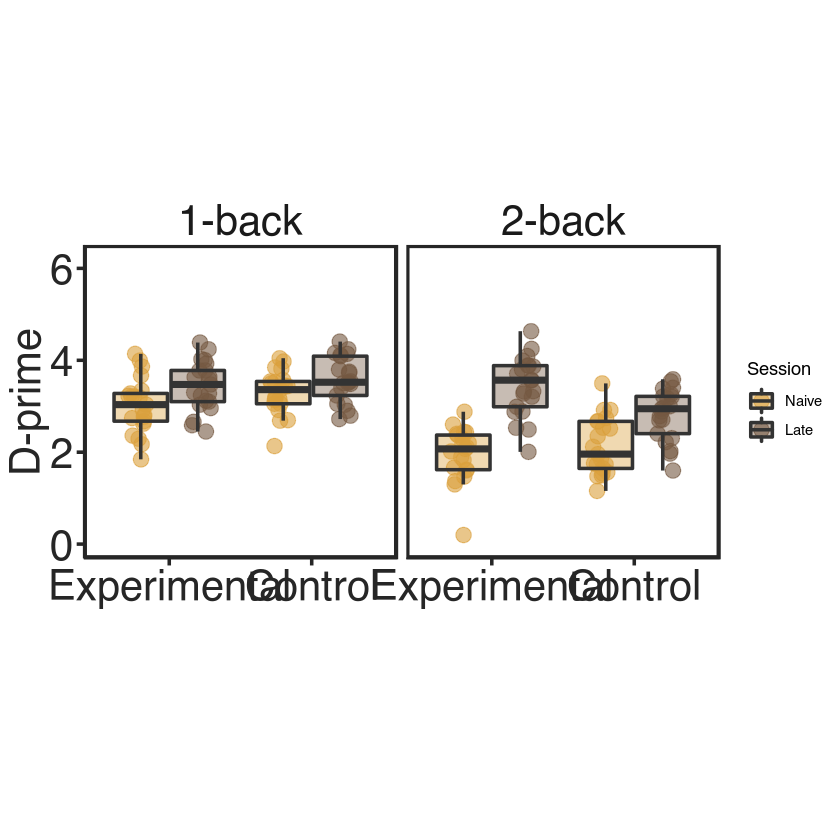

In [70]:
p <- performance %>% filter(Session %in% c('Naive', 'Late')) %>%
    ggplot(aes(x = Group, y = Dprime, fill = Session)) + 
    geom_point(aes(col = Session), position=position_jitterdodge(dodge.width=0.9), alpha = 0.6, size = 4) +
    geom_boxplot(alpha = 0.4, outlier.shape = NA, position=position_dodge(width=0.8), size = 1) + 
    scale_fill_manual(values=c('#daa03d', '#755841')) +
    scale_color_manual(values=c('#daa03d', '#755841')) +
    facet_wrap(~Condition) +
    ylim(0, 6.2) +
    ylab('D-prime') +
    xlab(' ') +
    theme_training
p

ggsave("figures/dprime_ttests.pdf", plot = p, width = 12, height = 6, dpi = 300)  

---------

# Block-to-block variability

In [66]:
head(performance)

Subject,Session,Condition,Accuracy,pRT,Dprime,Group
sub-01,Naive,1-back,0.8666667,1001.033,3.437119,Control
sub-01,Naive,2-back,0.7833333,1433.765,2.514055,Control
sub-01,Early,1-back,0.8666667,1003.172,3.429125,Control
sub-01,Early,2-back,0.8666667,1282.489,3.117902,Control
sub-01,Middle,1-back,0.8000000,1178.238,2.758558,Control
sub-01,Middle,2-back,0.9000000,1108.405,3.460899,Control


In [55]:
performance_variability <- read.csv('data/behavioral/WM_fmri_behaviour_variability_tidy.csv')
performance_variability$Group <- factor(performance_variability$Group, levels = c('Control', 'Experimental'))
performance_variability$Session <- factor(performance_variability$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))

performance_variability <- performance_variability %>% 
                            filter(!(Subject %in% c('sub-13', 'sub-21', 'sub-23', 'sub-50')))


head(performance_variability)

Subject,Session,Accuracy_std,pRT_std,Dprime_std,Group
sub-01,Naive,0.14409680,247.9006,0.8829726,Control
sub-01,Naive,0.10000000,210.0876,0.5344575,Control
sub-01,Early,0.13844373,183.4413,0.7998220,Control
sub-01,Early,0.11666667,155.0257,0.8416775,Control
sub-02,Middle,0.19913005,238.7242,1.1430880,Control
sub-02,Middle,0.08164966,160.8744,0.5703609,Control


## pRT variability

In [56]:
baseline <- lme(pRT_std ~ 1, random = ~ 1|Subject/Session, data = performance_variability, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)
session_group <- update(group, .~. + Session:Group)

anova(baseline, session, group, session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = pRT_std ~ 1, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,4,1814.210,1826.706,-903.1050,,NA,NA
session,"lme.formula(fixed = pRT_std ~ Session, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,7,1818.843,1840.710,-902.4213,1 vs 2,1.367442,0.713183934
group,"lme.formula(fixed = pRT_std ~ Session + Group, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,8,1813.454,1838.445,-898.7268,2 vs 3,7.389065,0.006562159
session_group,"lme.formula(fixed = pRT_std ~ Session + Group + Session:Group, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,11,1814.343,1848.706,-896.1713,3 vs 4,5.110849,0.163857844


In [57]:
summary(group)

Linear mixed-effects model fit by maximum likelihood
 Data: performance_variability 
       AIC      BIC    logLik
  1813.454 1838.445 -898.7268

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:    23.30172

 Formula: ~1 | Session %in% Subject
        (Intercept) Residual
StdDev:    1.955193 46.69144

Fixed effects: pRT_std ~ Session + Group 
                      Value Std.Error DF   t-value p-value
(Intercept)       237.26592  10.22987 84 23.193443  0.0000
SessionEarly        1.38900  10.36212 39  0.134045  0.8941
SessionMiddle      16.16022  12.68520 39  1.273943  0.2102
SessionLate        13.21321  12.68520 39  1.041624  0.3040
GroupExperimental -28.99616  10.35507 40 -2.800189  0.0078
 Correlation: 
                  (Intr) SssnEr SssnMd SssnLt
SessionEarly      -0.506                     
SessionMiddle     -0.600  0.408              
SessionLate       -0.600  0.408  0.666       
GroupExperimental -0.482  0.000 -0.039 -0.039

Standardized Within-Group Residuals:


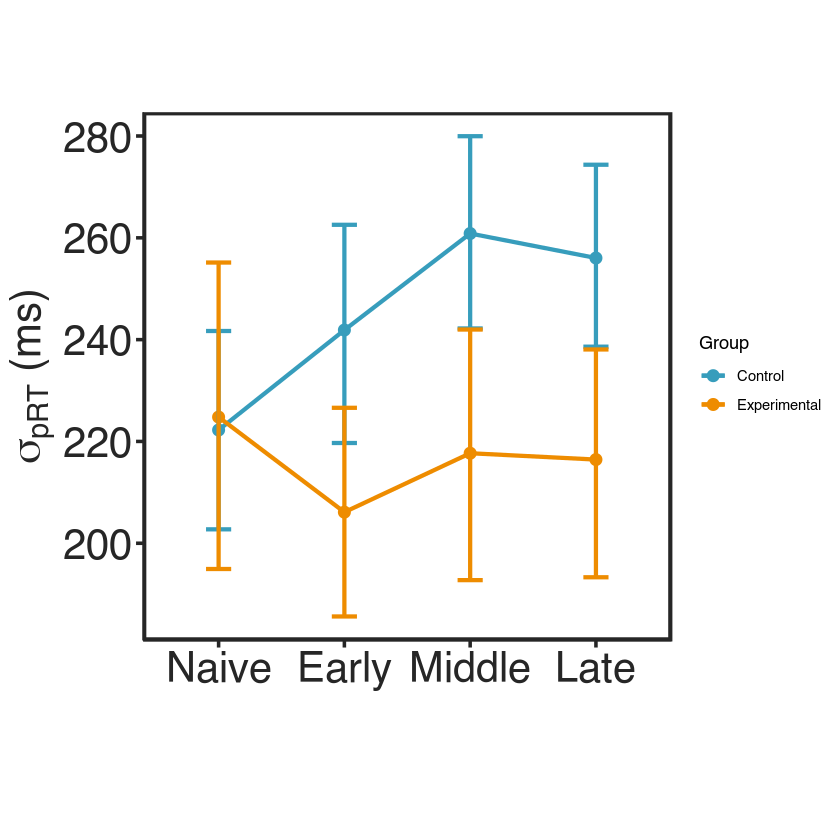

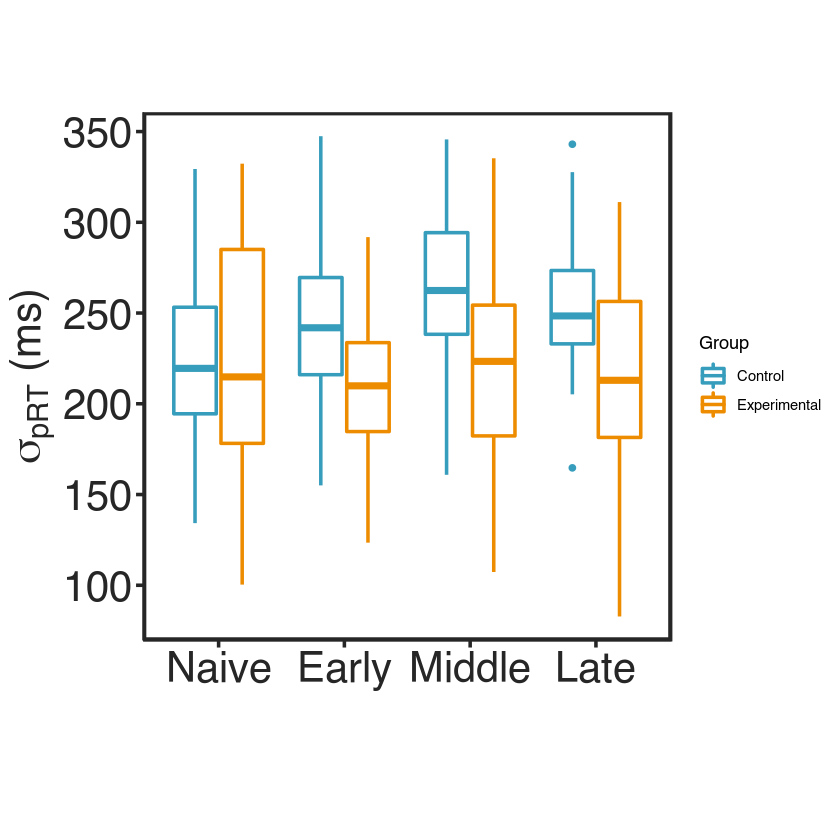

In [61]:
p <- ggplot(performance_variability, aes(x = Session, y = pRT_std, col = Group)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    theme_training +
    ylab(expression(paste(sigma ['pRT'], ' (ms)'))) +
    xlab('') 
p

p <- ggplot(performance_variability, aes(x = Session, y = pRT_std,col=Group)) +
    geom_boxplot(size=1) +
    ylab(expression(paste(sigma ['pRT'], ' (ms)'))) +
    xlab('') + 
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    theme_training
p


## D-prime variability

In [58]:
baseline <- lme(Dprime_std ~ 1, random = ~ 1|Subject/Session, data = performance_variability, method = 'ML',  control = list(opt = "optim"), na.action = na.exclude)
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)
session_group <- update(group, .~. + Session:Group)

anova(baseline, session, group, session_group)

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = Dprime_std ~ 1, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",1,4,85.93606,98.43192,-38.96803,,NA,NA
session,"lme.formula(fixed = Dprime_std ~ Session, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",2,7,82.32455,104.19230,-34.16227,1 vs 2,9.611517,0.02217413
group,"lme.formula(fixed = Dprime_std ~ Session + Group, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",3,8,80.90984,105.90155,-32.45492,2 vs 3,3.414709,0.06461782
session_group,"lme.formula(fixed = Dprime_std ~ Session + Group + Session:Group, data = performance_variability, random = ~1 | Subject/Session, method = ""ML"", na.action = na.exclude, control = list(opt = ""optim""))",4,11,82.05778,116.42138,-30.02889,3 vs 4,4.852063,0.18295588


In [59]:
summary(session)

Linear mixed-effects model fit by maximum likelihood
 Data: performance_variability 
       AIC      BIC    logLik
  82.32455 104.1923 -34.16227

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:   0.1663237

 Formula: ~1 | Session %in% Subject
        (Intercept)  Residual
StdDev: 0.002778858 0.2631689

Fixed effects: Dprime_std ~ Session 
                   Value  Std.Error DF   t-value p-value
(Intercept)    0.9862164 0.05512745 84 17.889752  0.0000
SessionEarly  -0.1432703 0.05813076 39 -2.464621  0.0182
SessionMiddle  0.0414595 0.07796199 39  0.531791  0.5979
SessionLate   -0.0558223 0.07796199 39 -0.716019  0.4782
 Correlation: 
              (Intr) SssnEr SssnMd
SessionEarly  -0.527              
SessionMiddle -0.707  0.373       
SessionLate   -0.707  0.373  0.722

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.25930283 -0.63063210 -0.05160684  0.52971618  2.99669535 

Number of Observations: 168
Number of G

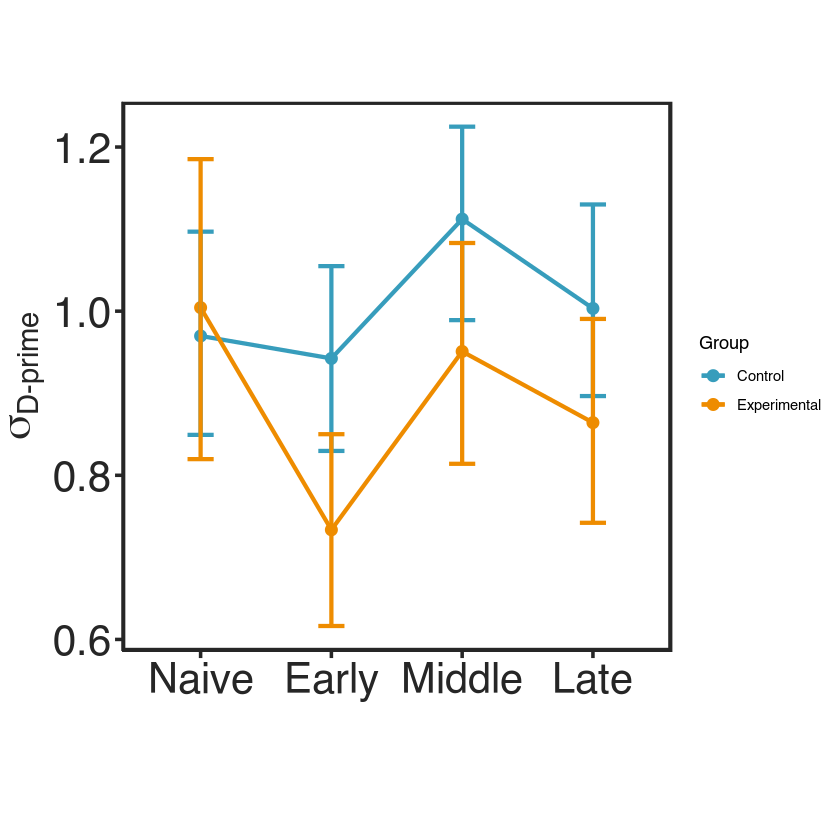

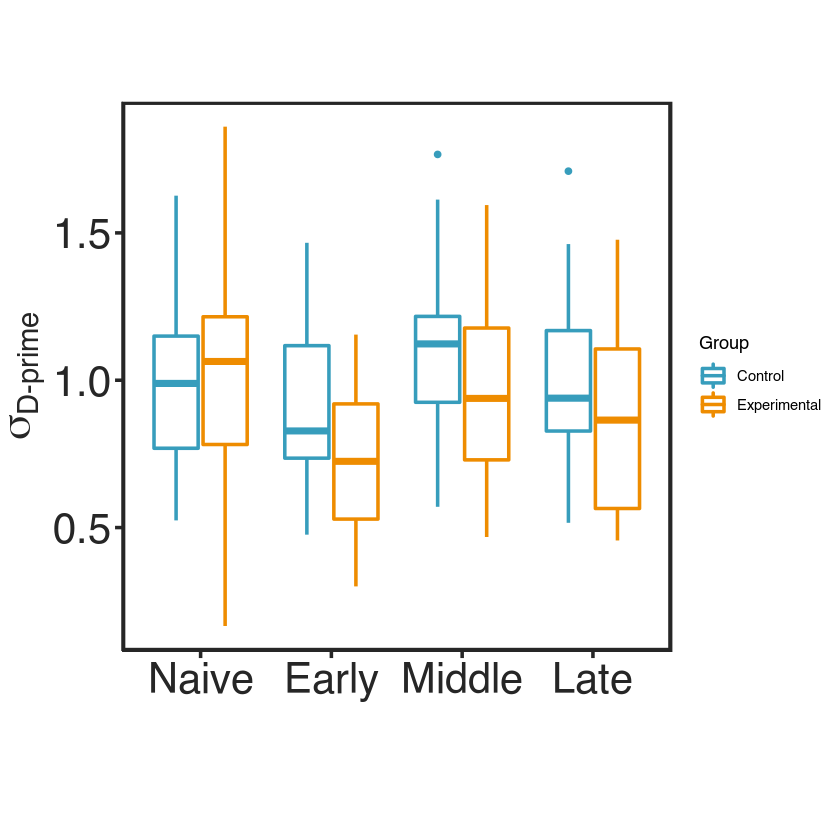

In [62]:
p <- ggplot(performance_variability, aes(x = Session, y = Dprime_std, col = Group)) +
    stat_summary(fun.y = mean, geom = 'point', size = 3) +
    stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
    stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    theme_training +
    ylab(expression(paste(sigma['D-prime']))) +
    xlab('') 
p

p <- ggplot(performance_variability, aes(x = Session, y = Dprime_std, col = Group)) +
    geom_boxplot(size=1) +
    ylab(expression(paste(sigma['D-prime']))) +
    xlab('') + 
    scale_colour_manual(values=c('#379dbc','#ee8c00')) +
    theme_training
p
